In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import timedelta, datetime

In [4]:
np.random.seed(42)

In [6]:
start_date = datetime.strptime("2023-01-01", "%Y-%m-%d")
date_range = [start_date + timedelta(days=i) for i in range(180)]

In [8]:
channels = ['Email', 'Chat', 'Phone']
channel_weights = [0.5, 0.3, 0.2]

In [9]:
data = []

for date in date_range:
    for channel in channels:
        # Normal behavior
        avg_handling_time = np.random.normal(loc=15, scale=3) if channel != 'Phone' else np.random.normal(20, 5)
        sla_met_pct = np.random.normal(loc=92, scale=4)
        tickets_resolved = np.random.poisson(lam=100 if channel == 'Email' else 60 if channel == 'Chat' else 40)
        agents_available = np.random.randint(10, 20)

        # Inject random anomalies on 5% of days
        is_anomaly = np.random.rand() < 0.05
        if is_anomaly:
            # Inject spikes or drops randomly
            anomaly_type = random.choice(['handling_spike', 'sla_drop'])
            if anomaly_type == 'handling_spike':
                avg_handling_time *= np.random.uniform(1.5, 2.2)  # Spike
            elif anomaly_type == 'sla_drop':
                sla_met_pct *= np.random.uniform(0.5, 0.7)  # Drop
            anomaly_flag = 1
        else:
            anomaly_flag = 0
        avg_handling_time = max(5, round(avg_handling_time, 2))
        sla_met_pct = min(100, max(50, round(sla_met_pct, 2)))

        data.append([
            date.strftime('%Y-%m-%d'),
            channel,
            avg_handling_time,
            sla_met_pct,
            tickets_resolved,
            agents_available,
            anomaly_flag
        ])

In [11]:
df_anomaly = pd.DataFrame(data, columns=[
    'date', 'channel', 'avg_handling_time', 'sla_met_pct',
    'tickets_resolved', 'agents_available', 'anomaly_flag'
])


df_anomaly.to_csv("operational_metrics_with_anomalies.csv", index=False)


df_anomaly.head()

,date,channel,avg_handling_time,sla_met_pct,tickets_resolved,agents_available,anomaly_flag
0,2023-01-01,Email,16.49,91.45,107,16,0
1,2023-01-01,Chat,14.72,61.27,56,12,1
2,2023-01-01,Phone,17.65,94.17,33,19,0
3,2023-01-02,Email,9.83,89.75,103,12,0
4,2023-01-02,Chat,14.93,93.42,70,18,0


In [15]:
print(df_anomaly.info())
print(df_anomaly.isnull().sum())
print(df_anomaly.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               540 non-null    object 
 1   channel            540 non-null    object 
 2   avg_handling_time  540 non-null    float64
 3   sla_met_pct        540 non-null    float64
 4   tickets_resolved   540 non-null    int64  
 5   agents_available   540 non-null    int64  
 6   anomaly_flag       540 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 29.7+ KB
None
date                 0
channel              0
avg_handling_time    0
sla_met_pct          0
tickets_resolved     0
agents_available     0
anomaly_flag         0
dtype: int64
       avg_handling_time  sla_met_pct  tickets_resolved  agents_available  \
count         540.000000   540.000000        540.000000        540.000000   
mean           17.330926    91.301889         67.216667         14.4

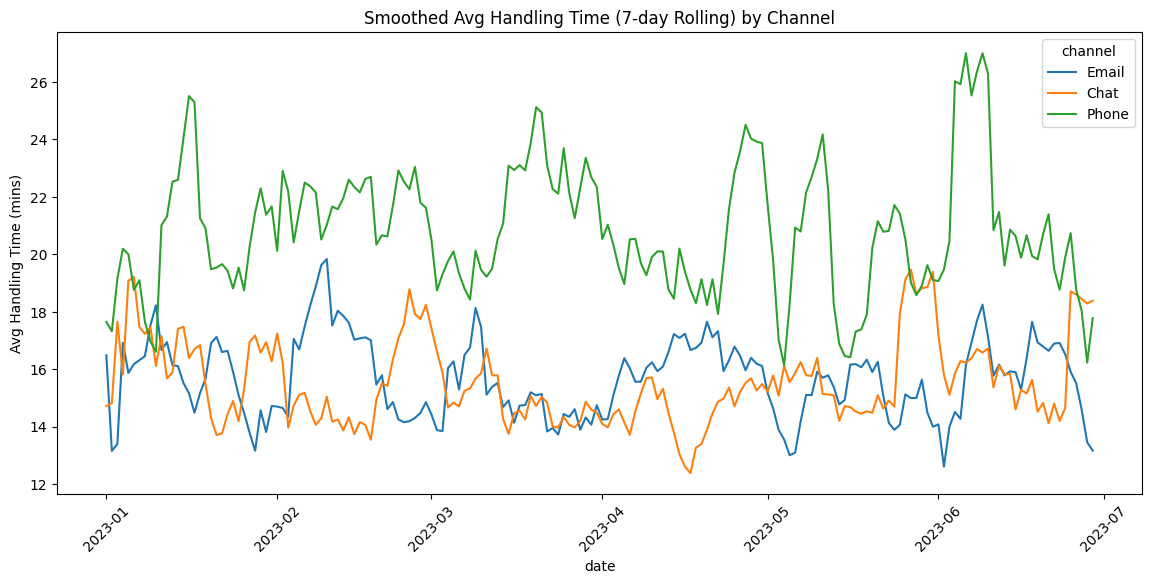

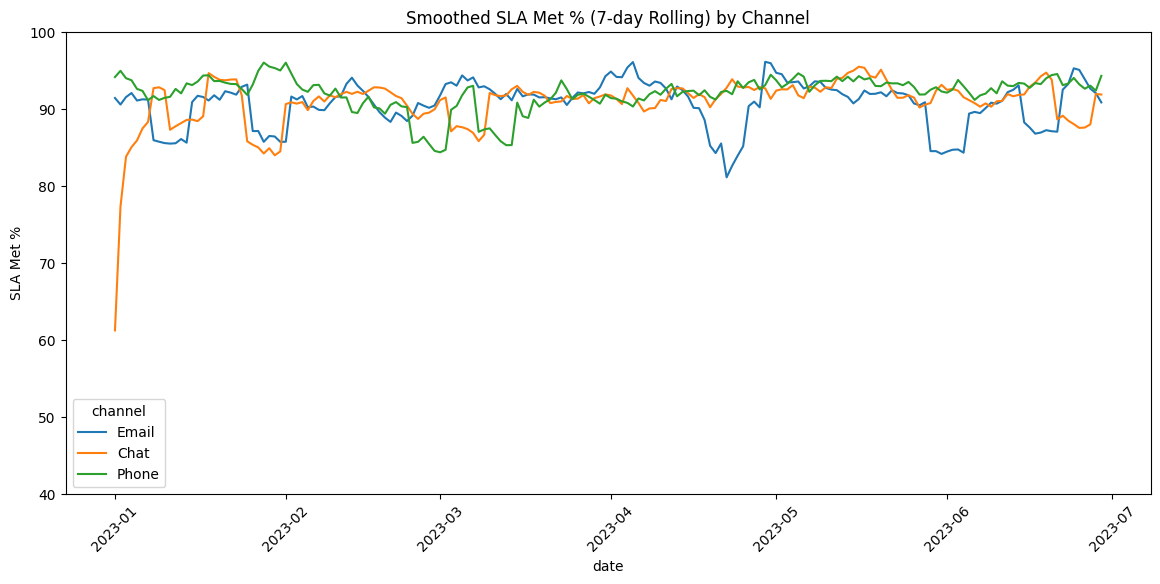

In [44]:
# Add 7-day rolling averages
df_anomaly['rolling_handling_time'] = df_anomaly.groupby('channel')['avg_handling_time'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df_anomaly['rolling_sla'] = df_anomaly.groupby('channel')['sla_met_pct'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Smoothed Avg Handling Time
plt.figure(figsize=(14,6))
sns.lineplot(data=df_anomaly, x='date', y='rolling_handling_time', hue='channel')
plt.title("Smoothed Avg Handling Time (7-day Rolling) by Channel")
plt.ylabel("Avg Handling Time (mins)")
plt.xticks(rotation=45)
plt.show()

# Smoothed SLA %
plt.figure(figsize=(14,6))
sns.lineplot(data=df_anomaly, x='date', y='rolling_sla', hue='channel')
plt.title("Smoothed SLA Met % (7-day Rolling) by Channel")
plt.ylabel("SLA Met %")
plt.ylim(40, 100)
plt.xticks(rotation=45)
plt.show()


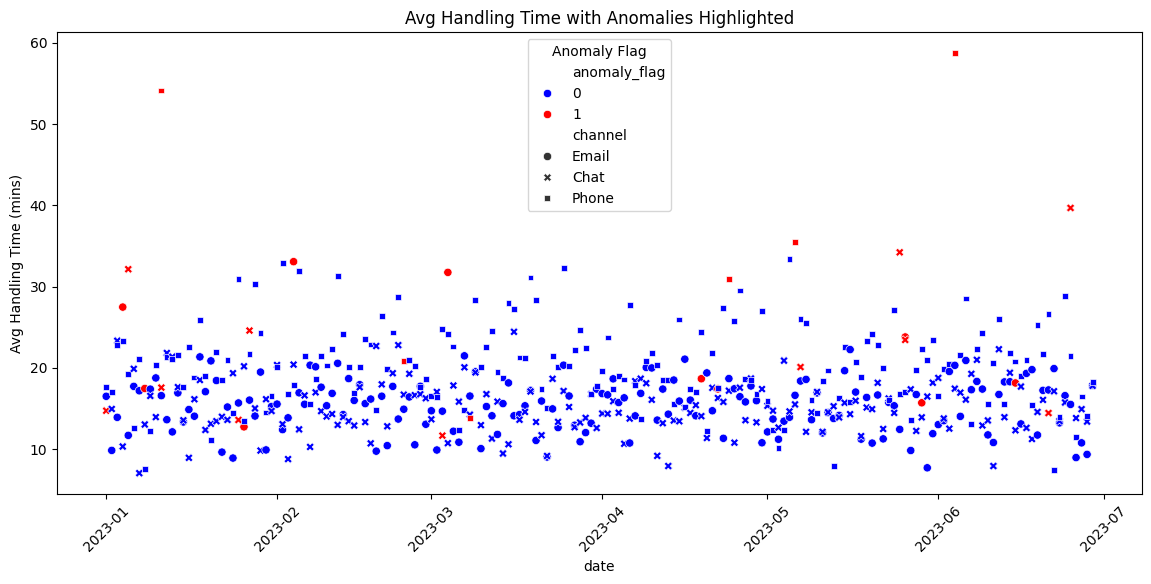

In [23]:
plt.figure(figsize=(14,6))
sns.scatterplot(data=df_anomaly, x='date', y='avg_handling_time', hue='anomaly_flag', palette={0:'blue', 1:'red'}, style='channel')
plt.title("Avg Handling Time with Anomalies Highlighted")
plt.ylabel("Avg Handling Time (mins)")
plt.xticks(rotation=45)
plt.legend(title='Anomaly Flag')
plt.show()


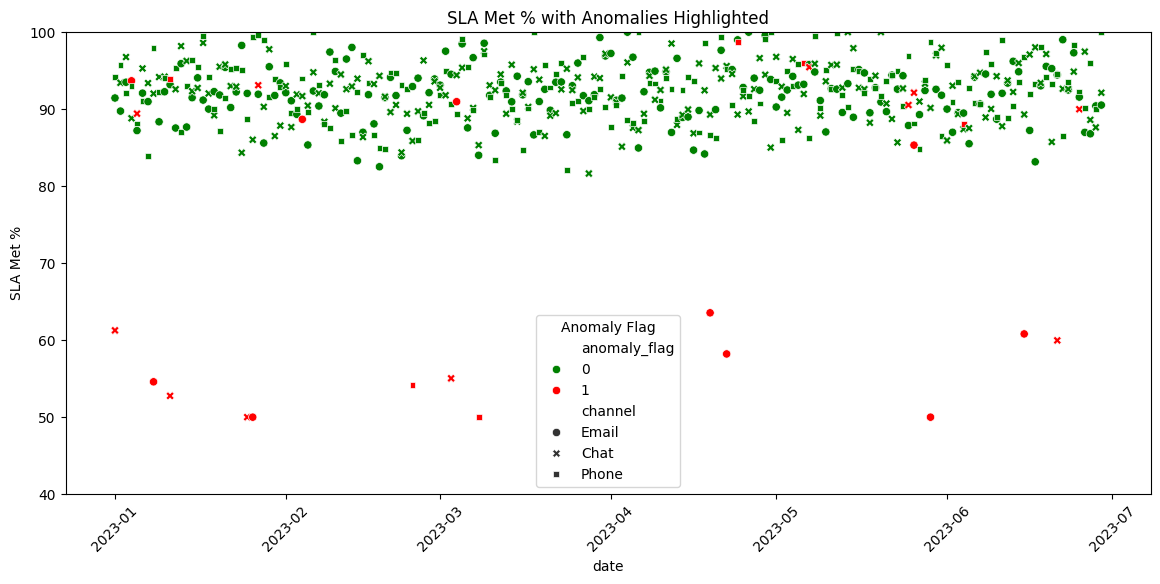

In [24]:
plt.figure(figsize=(14,6))
sns.scatterplot(data=df_anomaly, x='date', y='sla_met_pct', hue='anomaly_flag', palette={0:'green', 1:'red'}, style='channel')
plt.title("SLA Met % with Anomalies Highlighted")
plt.ylabel("SLA Met %")
plt.ylim(40, 100)
plt.xticks(rotation=45)
plt.legend(title='Anomaly Flag')
plt.show()

In [27]:
#Data Preprocessing (Scaling & Encoding)
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [28]:
le = LabelEncoder()
df_anomaly['channel_encoded'] = le.fit_transform(df_anomaly['channel'])

In [29]:
features = ['avg_handling_time', 'sla_met_pct', 'tickets_resolved', 'agents_available', 'channel_encoded']

In [31]:
# Scale features
scaler = StandardScaler()
df_anomaly_scaled = scaler.fit_transform(df_anomaly[features])

print(f"Scaled features shape: {df_anomaly_scaled.shape}")

Scaled features shape: (540, 5)


In [33]:
#Detection
df_anomaly['z_avg_handling_time'] = (df_anomaly['avg_handling_time'] - df_anomaly['avg_handling_time'].mean()) / df_anomaly['avg_handling_time'].std()
df_anomaly['z_sla_met_pct'] = (df_anomaly['sla_met_pct'] - df_anomaly['sla_met_pct'].mean()) / df_anomaly['sla_met_pct'].std()

In [35]:
threshold = 3

# Flag anomalies based on either metric exceeding threshold
df_anomaly['zscore_anomaly'] = ((np.abs(df_anomaly['z_avg_handling_time']) > threshold) | (np.abs(df_anomaly['z_sla_met_pct']) > threshold)).astype(int)

In [37]:
from sklearn.metrics import classification_report

print(classification_report(df_anomaly['anomaly_flag'], df_anomaly['zscore_anomaly']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       513
           1       1.00      0.67      0.80        27

    accuracy                           0.98       540
   macro avg       0.99      0.83      0.90       540
weighted avg       0.98      0.98      0.98       540



In [39]:
#Isolation Forest
from sklearn.ensemble import IsolationForest

In [41]:
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(df_anomaly_scaled)

# Predict anomalies (-1 for anomaly, 1 for normal)
df_anomaly['iforest_anomaly'] = clf.predict(df_anomaly_scaled)
df_anomaly['iforest_anomaly'] = df_anomaly['iforest_anomaly'].map({1: 0, -1: 1})

print(classification_report(df_anomaly['anomaly_flag'], df_anomaly['iforest_anomaly']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       513
           1       0.81      0.81      0.81        27

    accuracy                           0.98       540
   macro avg       0.90      0.90      0.90       540
weighted avg       0.98      0.98      0.98       540



In [42]:
#Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

In [45]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df_anomaly['lof_anomaly'] = lof.fit_predict(df_anomaly_scaled)
df_anomaly['lof_anomaly'] = df_anomaly['lof_anomaly'].map({1: 0, -1: 1})

print(classification_report(df_anomaly['anomaly_flag'], df_anomaly['lof_anomaly']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       513
           1       0.85      0.85      0.85        27

    accuracy                           0.99       540
   macro avg       0.92      0.92      0.92       540
weighted avg       0.99      0.99      0.99       540



### Conclusion
#### Operational fluctuations are normal across Email, Chat, and Phone channels, with Phone showing higher average handling time due to call duration variability.
#### The use of rolling averages and faceted plots significantly improved interpretability of long-term trends and anomalies across channels.